In [1]:
import gurobipy as gp
from gurobipy import GRB
import random
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import warnings
from tqdm import tqdm_notebook as tqdm
import requests
import json
import API
import matplotlib.pyplot as plt
import GoogleDistanceMatrix
import GoogleVRP
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

# Current shared

In [46]:
order = pd.read_excel('../1. Sales Data/DMS order_2-6Nov2020 (Only store with DMS available)+Transportation.xlsx')
order = order.loc[order['Instant Order']==True]
store = pd.read_csv('Data/StoreLocation.csv')

In [236]:
order['orderTime'] = pd.to_datetime(order['下單時間'])
order['arrivalTime'] = pd.to_datetime(order['訂單送達時間'])
order['departureTime'] = pd.to_datetime(order['取餐出發時間'])

order['waitingTime'] = order['arrivalTime'] - order['orderTime']
order['tripDurationReal'] = pd.to_datetime(order['訂單送達時間']) - pd.to_datetime(order['departureTime'])
order['tripDurationReal'] = order['tripDurationReal'].dt.seconds

In [224]:
order.shape

(60, 32)

In [237]:
order['waitingTime'].describe()

count                       503
mean     0 days 00:36:09.552683
std      0 days 00:12:28.852046
min             0 days 00:16:02
25%      0 days 00:27:39.500000
50%             0 days 00:33:46
75%             0 days 00:41:05
max             0 days 01:33:23
Name: waitingTime, dtype: object

In [238]:
order = order.sort_values(by=['取餐出發時間','Rider'])
order['last取餐出發時間'] = order['取餐出發時間'].shift(1)
order['lastRider'] = order['Rider'].shift(1)
order['pre取餐出發時間'] = order['取餐出發時間'].shift(-1)
order['preRider'] = order['Rider'].shift(-1)

In [239]:
shared = order.loc[((order['last取餐出發時間']==order['取餐出發時間'])&(order['lastRider']==order['Rider']))|
                   ((order['pre取餐出發時間']==order['取餐出發時間'])&(order['preRider']==order['Rider']))]
single = order.loc[((order['last取餐出發時間']!=order['取餐出發時間'])|(order['lastRider']!=order['Rider']))|
                   ((order['pre取餐出發時間']!=order['取餐出發時間'])|(order['preRider']!=order['Rider']))]

In [240]:
shared['waitingTime'].describe()

count                       138
mean     0 days 00:42:49.384057
std      0 days 00:14:43.388014
min             0 days 00:20:14
25%      0 days 00:33:24.250000
50%      0 days 00:39:02.500000
75%      0 days 00:47:22.500000
max             0 days 01:33:23
Name: waitingTime, dtype: object

In [241]:
single['waitingTime'].describe()

count                       499
mean     0 days 00:36:01.466933
std      0 days 00:12:18.852885
min             0 days 00:16:02
25%      0 days 00:27:39.500000
50%             0 days 00:33:43
75%             0 days 00:40:49
max             0 days 01:33:23
Name: waitingTime, dtype: object

## data preprocessing

In [125]:
def get_lat_lon(x):
    location = x['配送地址']
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address=香港'+location+'&key='+API.key
    data = requests.get(url)
    text = json.loads(data.text)
    if text['results'] == []:
        return('missing')
    lat = str(text['results'][0]['geometry']['location']['lat'])
    lng = str(text['results'][0]['geometry']['location']['lng'])
    return(lat+','+lng)

In [126]:
order['DeliveryLatLon'] = order.apply(get_lat_lon,axis=1)

In [130]:
def tripDurationFromGoogle(x):
    StoreLatLon,DeliveryLatLon = x['StoreLatLon'],x['DeliveryLatLon']
    url = 'https://maps.googleapis.com/maps/api/directions/json?origin='+StoreLatLon+\
    '&destination='+DeliveryLatLon+'&mode=driving&key='+API.key
    data = requests.get(url)
    text = json.loads(data.text)
    if text['routes'] == []:
        return 'missing'
         
    else:
        duration = text['routes'][0]['legs'][0]['duration']['value']
        return duration

In [84]:
order = order[['日期', '門店名稱', '配送地址', '下單時間', '指派成功時間', '騎手接單時間', '到店取餐時間', '取餐出發時間',
       '訂單送達時間', '預送達時間', 'Banner', 'Instant Order', '收貨地址坐標', 'Rider',
       'Transportation', 'orderTime', 'arrivalTime', 'waitingTime',
       'last取餐出發時間', 'lastRider', 'departureTime', 'tripDurationReal',
       'DeliveryLatLon']]

In [85]:
order = order.merge(store, how='left',left_on='門店名稱', right_on='storeCode')
order['StoreLatLon'] = order['lat'].astype(str)+','+order['lon'].astype(str)

In [131]:
order['tripDurationFromGoogle'] = order.apply(lambda x:tripDurationFromGoogle(x),axis=1)

In [150]:
order = order.loc[order['tripDurationFromGoogle']!='missing']
order['tripDurationFromGoogle'] = order['tripDurationFromGoogle'].astype(int)

In [242]:
order['shared'] = 0
order.loc[((order['last取餐出發時間']==order['取餐出發時間'])&(order['lastRider']==order['Rider']))|
                   ((order['pre取餐出發時間']==order['取餐出發時間'])&(order['preRider']==order['Rider'])),'shared'] = 1

In [269]:
order.loc[order['shared']==0]['tripDurationFromGoogle'].mean()/60

7.692191780821918

In [270]:
order.loc[order['shared']==0]['tripDurationReal'].mean()/60

15.16579908675799

In [271]:
timeParameter = (order['tripDurationReal']/60).mean() / (order['tripDurationFromGoogle']/60).mean()
timeParameter

2.142449731214544

In [211]:
order['foodPreparationTime'] = pd.to_datetime(order['取餐出發時間']) - pd.to_datetime(order['下單時間'])

In [212]:
order.loc[order['shared']==0]['foodPreparationTime'].mean()

Timedelta('0 days 00:19:12.092592')

In [213]:
order.loc[order['shared']==1]['foodPreparationTime'].mean()

Timedelta('0 days 00:24:21.577464')

In [243]:
order.to_csv('Data/ProcessedNov.csv',index=False)

## modelling

In [69]:
order = pd.read_csv('Data/ProcessedNov.csv')

In [70]:
order = order.loc[order['門店名稱'].isin(['PH64','PHD606'])]
order.shape

(194, 32)

In [71]:
order.loc[order['Rider']=='3rdParty'].shape

(7, 32)

In [72]:
order['foodPreparationTime'] = pd.to_datetime(order['取餐出發時間']) - pd.to_datetime(order['下單時間'])

In [73]:
order.loc[order['shared']==0]['foodPreparationTime'].mean()

Timedelta('0 days 00:17:39.373493')

In [74]:
order.loc[order['shared']==1]['foodPreparationTime'].mean()

Timedelta('0 days 00:19:36.678571')

In [75]:
from scipy import stats
stats.ttest_ind(order.loc[order['shared']==0]['foodPreparationTime'].dt.seconds,
                order.loc[order['shared']==1]['foodPreparationTime'].dt.seconds)

Ttest_indResult(statistic=-0.9840331209381342, pvalue=0.3263376141515504)

In [76]:
order = order[['orderTime', 'arrivalTime', 'foodPreparationTime','waitingTime', 'departureTime', 'tripDurationReal',
       'DeliveryLatLon', 'storeCode', 'StoreLatLon',
       'tripDurationFromGoogle', 'shared']]

In [77]:
order['departureTime'] = pd.to_datetime(order['departureTime'])
order['hour'] = order['departureTime'].dt.hour
order['min'] = order['departureTime'].dt.minute
order['min'] = order['min'].apply(lambda x: (int(x/5)+1)*5)

In [78]:
order['timeWindow'] = pd.Timedelta('0 days 00:50:00') - order['foodPreparationTime']
order['timeWindow'] = order['timeWindow'].dt.seconds


In [79]:
order = order.loc[order['tripDurationReal']>=order['tripDurationFromGoogle']]

In [80]:
order.tripDurationReal.describe()

count     162.000000
mean     1017.302469
std       426.882736
min       325.000000
25%       719.000000
50%       965.000000
75%      1212.000000
max      2378.000000
Name: tripDurationReal, dtype: float64

In [81]:
order['timeParameter'] = order['tripDurationReal']/order['tripDurationFromGoogle']
timeParameter = order.groupby(['hour','min','shared']).agg({'timeParameter':'mean'}).reset_index()
timeParameter = timeParameter.loc[timeParameter['shared']==0]
del timeParameter['shared']
del order['timeParameter']

In [82]:
order = order.merge(timeParameter,on=['hour','min'])

In [83]:
timeParameter.mean()

hour             16.921053
min              33.157895
timeParameter     2.518449
dtype: float64

In [84]:
order.loc[order['timeWindow'] < order['tripDurationReal'],'timeWindow'] = \
order.loc[order['timeWindow'] < order['tripDurationReal'],'tripDurationReal']

In [85]:
rider_df = pd.read_excel('../1. Sales Data/2-6Nov - Clock in record.xls')
rider_df['Clock in.1'] = pd.to_datetime(rider_df['Clock in.1'])
rider_df['Date'] = rider_df['Clock in.1'].dt.day

In [86]:
PHDLatLon = order.loc[order['storeCode']=='PHD606']['StoreLatLon'].values[0]
PHLatLon = order.loc[order['storeCode']=='PH64']['StoreLatLon'].values[0]


In [87]:
order['tripTime'] = 0
order['rider'] = 0

In [88]:
PHD_output = pd.DataFrame()
PH_output = pd.DataFrame()

In [89]:
order.tripDurationReal.describe()

count     157.000000
mean     1018.751592
std       426.420096
min       325.000000
25%       728.000000
50%       966.000000
75%      1209.000000
max      2378.000000
Name: tripDurationReal, dtype: float64

In [90]:
order.head()

,orderTime,arrivalTime,foodPreparationTime,waitingTime,departureTime,tripDurationReal,DeliveryLatLon,storeCode,StoreLatLon,tripDurationFromGoogle,shared,hour,min,timeWindow,timeParameter,tripTime,rider
0,2020-11-02 11:22:00,2020-11-02 11:44:59,00:12:54,0 days 00:22:59.000000000,2020-11-02 11:34:54,605,"22.2847577,114.1326485",PH64,"22.284392699999998,114.141973",487,0,11,35,2226,1.864117,0,0
1,2020-11-06 11:26:00,2020-11-06 11:49:43,00:07:31,0 days 00:23:43.000000000,2020-11-06 11:33:31,972,"22.2863114,114.1452516",PH64,"22.284392699999998,114.141973",391,0,11,35,2549,1.864117,0,0
2,2020-11-02 12:15:00,2020-11-02 12:46:43,00:17:51,0 days 00:31:43.000000000,2020-11-02 12:32:51,832,"22.2847577,114.1326485",PH64,"22.284392699999998,114.141973",487,0,12,35,1929,1.584512,0,0
3,2020-11-06 11:52:00,2020-11-06 12:48:47,00:40:43,0 days 00:56:47.000000000,2020-11-06 12:32:43,964,"22.2746457,114.1631178",PHD606,"22.284361999999998,114.13979259999999",660,0,12,35,964,1.584512,0,0
4,2020-11-02 12:24:00,2020-11-02 12:50:37,00:20:01,0 days 00:26:37.000000000,2020-11-02 12:44:01,396,"22.2850494,114.1377722",PH64,"22.284392699999998,114.141973",214,0,12,45,1799,2.473491,0,0


In [91]:
order['tripTime'] = 0
order['rider'] = 0
order['delayed'] = 0
order['departureTimeSimulation'] = pd.to_datetime(order.orderTime).dt.date.astype(str)+' '+order['hour'].apply(lambda x:str(x).zfill(2))+\
                                        ':'+order['min'].apply(lambda x:str(x).zfill(2))+':00'
PHD_output = pd.DataFrame()
PH_output = pd.DataFrame()

In [92]:
for day in range(2,7):
    # reset riders
    riders = rider_df.loc[(rider_df['Rider Store Code'].isin([64,606]))&(rider_df['Date']==day)]['Rider No.'].unique()
    riderStatus = {}
    for i in (riders):
        riderStatus[i] = 0
    for hour in range(11,24):
        for minute in np.arange(0,60,5):
            # update rider status at current time
            for key in riderStatus.keys():
                if riderStatus[key]!= 0:
                    if riderStatus[key] <= pd.to_datetime('2020-11-0%s %s:%s:00'%(day,hour,str(minute).zfill(2))):
                        riderStatus[key] = 0

            candidate = order.loc[(pd.to_datetime(order['orderTime']).dt.day==day)&(order['hour']==hour)&(order['min']==minute)]
            if len(candidate) > 0:
                PHD = candidate.loc[candidate['storeCode']=='PHD606']
                PH = candidate.loc[candidate['storeCode']=='PH64']
                timeParameter = order.loc[(order['hour']==hour)&(order['min']==minute)]['timeParameter'].unique()[0]

                if len(PHD) > 0:
                    if len(PHD) >1:

                        adderess = [PHDLatLon] + PHD['DeliveryLatLon'].values.tolist()
                        distance_matrix = GoogleDistanceMatrix.get_distance_matrix(API.key, adderess)
                        time_window_point = [int(i) for i in PHD['timeWindow'].values]
                        zeros = [int(i) for i in np.zeros(len(PHD))]
                        time_window_matrix = [(int(0),int(0))]+list(zip(zeros,time_window_point))
                        
            #             if no rider available, assign orders to the next slot
                        if len([key for key in riderStatus.keys() if riderStatus[key] == 0]) > 0:
                            total_rider = len([key for key in riderStatus.keys() if riderStatus[key] == 0])
                            
                            
                            vehicle_route,vehicle_back_distance,vehicle_deliver_distance,vehicle = \
                            GoogleVRP.VRPTW(distance_matrix,time_window_matrix,1,total_rider)
                            
                            selectRider = random.sample([key for key in riderStatus.keys() 
                                                         if riderStatus[key] == 0], vehicle)
                            
                            departure_time = pd.to_datetime('2020-11-0%s %s:%s:00'%(day,hour,str(minute).zfill(2)))
                            
                            for ind,rider in enumerate(selectRider):
                                back_time = departure_time + pd.Timedelta(vehicle_back_distance[ind], 'seconds')*timeParameter
                                riderStatus[rider] = back_time
                            
                            node_deliver_sequnce = []
                            node_deliver_time = []
                            for vehicle_no in vehicle_route.keys():
                                time = 0

                                for ind,node in enumerate(vehicle_route[vehicle_no]):
                                    if node == 0:
                                        next
                                    else:
                                        time = distance_matrix[vehicle_route[vehicle_no][ind]-1][node]*2.2 + time
                                        node_deliver_time += [time]
                                        node_deliver_sequnce += [node]

                            node_deliver_time_dict = dict(zip(node_deliver_sequnce,node_deliver_time))
                            node_deliver_time_dict = {k : node_deliver_time_dict[k] for k in sorted(node_deliver_time_dict)}
                            node_deliver_time = node_deliver_time_dict.values()
                            
                            PHD['tripTime'] = node_deliver_time
                            # if only one select rider, then length does not match
                            if len(selectRider) > 1:
                                PHD['rider'] = selectRider
                            else:
                                PHD['rider'] = selectRider[0]

                            PHD_output = pd.concat([PHD_output,PHD])
                        else:
                            order.loc[(order['hour']==hour)&(order['min']==minute)]['dalay'] = 1
                            if minute == 55:
                                order.loc[(order['hour']==hour)&(order['min']==minute)]['hour'] = hour+1
                                order.loc[(order['hour']==hour)&(order['min']==minute)]['min'] = 0
                            else:
                                order.loc[(order['hour']==hour)&(order['min']==minute)]['min'] = minute + 5

                    # only 1 order
                    elif len(PHD) == 1:
                        PHD['departureTimeSimulation'] = PHD['departureTime']
                        tripDurationReal = PHD['tripDurationReal'].values[0]
                        departure_time = PHD['departureTime'].values[0]
                        back_time = pd.to_datetime(departure_time) + pd.Timedelta(tripDurationReal*2, 'seconds')
                        if len([key for key in riderStatus.keys() if riderStatus[key] == 0]) > 0:
                            selectRider = random.sample([key for key in riderStatus.keys() if riderStatus[key] == 0], 1)[0]
                        riderStatus[selectRider] = back_time
                        PHD['tripTime'] = tripDurationReal
                        PHD['rider'] = selectRider
                        PHD_output = pd.concat([PHD_output,PHD])
                
                if len(PH) > 0:
                    if len(PH) >1:

                        adderess = [PHLatLon] + PH['DeliveryLatLon'].values.tolist()
                        distance_matrix = GoogleDistanceMatrix.get_distance_matrix(API.key, adderess)
                        time_window_point = [int(i) for i in PH['timeWindow'].values]
                        zeros = [int(i) for i in np.zeros(len(PH))]
                        time_window_matrix = [(int(0),int(0))]+list(zip(zeros,time_window_point))
                        
            #             if no rider available, assign orders to the next slot
                        if len([key for key in riderStatus.keys() if riderStatus[key] == 0]) > 0:
                            total_rider = len([key for key in riderStatus.keys() if riderStatus[key] == 0])
                            
                            
                            vehicle_route,vehicle_back_distance,vehicle_deliver_distance,vehicle = \
                            GoogleVRP.VRPTW(distance_matrix,time_window_matrix,1,total_rider)
                            
                            selectRider = random.sample([key for key in riderStatus.keys() 
                                                         if riderStatus[key] == 0], vehicle)
                            
                            departure_time = pd.to_datetime('2020-11-0%s %s:%s:00'%(day,hour,str(minute).zfill(2)))
                            
                            for ind,rider in enumerate(selectRider):
                                back_time = departure_time + pd.Timedelta(vehicle_back_distance[ind], 'seconds')*timeParameter
                                riderStatus[rider] = back_time
                            
                            node_deliver_sequnce = []
                            node_deliver_time = []
                            for vehicle_no in vehicle_route.keys():
                                time = 0

                                for ind,node in enumerate(vehicle_route[vehicle_no]):
                                    if node == 0:
                                        next
                                    else:
                                        time = distance_matrix[vehicle_route[vehicle_no][ind]-1][node]*2.2 + time
                                        node_deliver_time += [time]
                                        node_deliver_sequnce += [node]

                            node_deliver_time_dict = dict(zip(node_deliver_sequnce,node_deliver_time))
                            node_deliver_time_dict = {k : node_deliver_time_dict[k] for k in sorted(node_deliver_time_dict)}
                            node_deliver_time = node_deliver_time_dict.values()
                            
                            PH['tripTime'] = node_deliver_time
                            if len(selectRider) > 1:
                                PH['rider'] = selectRider
                            else:
                                PH['rider'] = selectRider[0]

                            PH_output = pd.concat([PH_output,PH])
                        else:
                            order.loc[(order['hour']==hour)&(order['min']==minute)]['dalay'] = 1
                            if minute == 55:
                                order.loc[(order['hour']==hour)&(order['min']==minute)]['hour'] = hour+1
                                order.loc[(order['hour']==hour)&(order['min']==minute)]['min'] = 0
                            else:
                                order.loc[(order['hour']==hour)&(order['min']==minute)]['min'] = minute + 5

                    # only 1 order
                    elif len(PH) == 1:
                        PH['departureTimeSimulation'] = PH['departureTime']
                        tripDurationReal = PH['tripDurationReal'].values[0]
                        departure_time = PH['departureTime'].values[0]
                        back_time = pd.to_datetime(departure_time) + pd.Timedelta(tripDurationReal*2, 'seconds')
                        if len([key for key in riderStatus.keys() if riderStatus[key] == 0]) > 0:
                            selectRider = random.sample([key for key in riderStatus.keys() if riderStatus[key] == 0], 1)[0]
                        riderStatus[selectRider] = back_time
                        PH['tripTime'] = tripDurationReal
                        PH['rider'] = selectRider
                        PH_output = pd.concat([PH_output,PH])



                

In [93]:
PH_output['arrivalTimeSimulation'] = pd.to_datetime(PH_output['departureTimeSimulation']) +\
                                        pd.to_timedelta(PH_output['tripTime'],'seconds')
PH_output['waitingTimeSimulation'] = PH_output['arrivalTimeSimulation'] - pd.to_datetime(PH_output['orderTime'])
PH_output['waitingTimeReal'] = pd.to_datetime(PH_output['arrivalTime']) - pd.to_datetime(PH_output['orderTime'])

In [94]:
PH_output['waitingTimeSimulation'].describe()

count                        67
mean     0 days 00:37:18.376119
std      0 days 00:12:54.671819
min             0 days 00:17:57
25%      0 days 00:29:50.500000
50%             0 days 00:34:12
75%      0 days 00:43:41.900000
max             0 days 01:23:19
Name: waitingTimeSimulation, dtype: object

In [95]:
PH_output['waitingTimeSimulation'].mean()

Timedelta('0 days 00:37:18.376119')

In [96]:
PH_output['waitingTimeReal'].mean()

Timedelta('0 days 00:35:07.313432')

<AxesSubplot:>

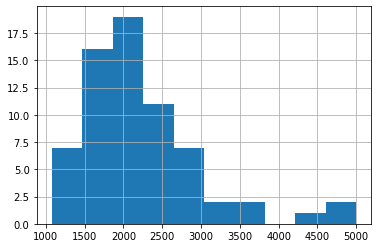

In [97]:
PH_output['waitingTimeSimulation'].dt.seconds.hist()

<AxesSubplot:>

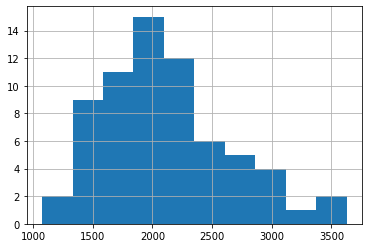

In [98]:
PH_output['waitingTimeReal'].dt.seconds.hist()

In [99]:

PHD_output['arrivalTimeSimulation'] = pd.to_datetime(PHD_output['departureTimeSimulation']) +\
                                        pd.to_timedelta(PHD_output['tripTime'],'seconds')
PHD_output['waitingTimeSimulation'] = PHD_output['arrivalTimeSimulation'] - pd.to_datetime(PHD_output['orderTime'])
PHD_output['waitingTimeReal'] = pd.to_datetime(PHD_output['arrivalTime']) - pd.to_datetime(PHD_output['orderTime'])

In [100]:
PHD_output['waitingTimeSimulation'].mean()

Timedelta('0 days 00:33:45.391891')

In [101]:
PHD_output['waitingTimeReal'].mean()

Timedelta('0 days 00:31:02.013513')

In [68]:
pd.concat([PHD_output,PH_output]).to_csv('Output/order11065min1vehAllDayStatic.csv',index=False)